In [1]:
using ReinforcementLearning, ReinforcementLearningEnvironments
using RLIntro.MaximizationBias

┌ Info: Precompiling ReinforcementLearning [158674fc-8238-5cab-b5ba-03dfc80d1318]
└ @ Base loading.jl:1264
┌ Info: Precompiling RLIntro [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1264
┌ Warning: Package RLIntro does not have StatsBase in its dependencies:
│ - If you have RLIntro checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RLIntro
└ Loading StatsBase into RLIntro from project dependency, future warnings for RLIntro are suppressed.


In [2]:
using Plots, StatsBase

In [3]:
mutable struct CountOfLeft <: AbstractHook
    counts::Vector{Int}
    count::Int
    CountOfLeft() = new([],0)
end

function (f::CountOfLeft)(::PreActStage, agent, env, obs_action)
    obs, action = obs_action
    if get_state(obs) == 1 && action == MaximizationBias.LEFT
        f.count += 1
    end
end

function (f::CountOfLeft)(::PostEpisodeStage, agent, env, obs)
    push!(f.counts, f.count)
    f.count = 0
end


In [4]:
env = MaximizationBiasEnv()
ns, na = length(observation_space(env)), length(action_space(env))

(3, 10)

In [5]:
init_double_Q_agent() = Agent(
    π=QBasedPolicy(
        learner=DoubleLearner(
            L1=TDLearner(
                approximator=TabularQApproximator(n_state=ns, n_action=na),
                optimizer=Descent(0.1),
                method=:SARS
                ),
            L2=TDLearner(
                approximator=TabularQApproximator(n_state=ns, n_action=na),
                optimizer=Descent(0.1),
                method=:SARS
                )
            ),
        selector=EpsilonGreedySelector(0.1)
        ),
    buffer=episode_RTSA_buffer()
)

init_Q_agent() = Agent(
    π=QBasedPolicy(
        learner=TDLearner(
            approximator=TabularQApproximator(n_state=ns, n_action=na),
            optimizer=Descent(0.1),
            method=:SARS
            ),
        selector=EpsilonGreedySelector(0.1)
        ),
    buffer=episode_RTSA_buffer()
)

init_Q_agent (generic function with 1 method)

Progress:   0%|▏                                        |  ETA: 0:02:51
4m  TRAINING/EPISODE:  0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  294


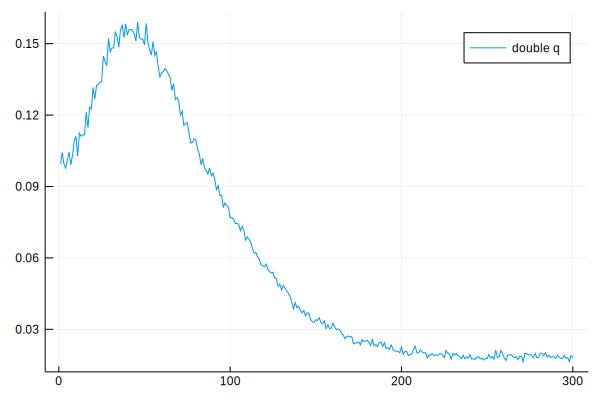

In [6]:
stats = []
for _ in 1:10000
    hook = CountOfLeft()
    run(init_double_Q_agent(), env, StopAfterEpisode(300);hook=hook)
    push!(stats, hook.counts)
end

plot(mean(stats), legend=:topright, label="double q")

Progress:   0%|▏                                        |  ETA: 0:00:48
4m  TRAINING/EPISODE:  0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  178


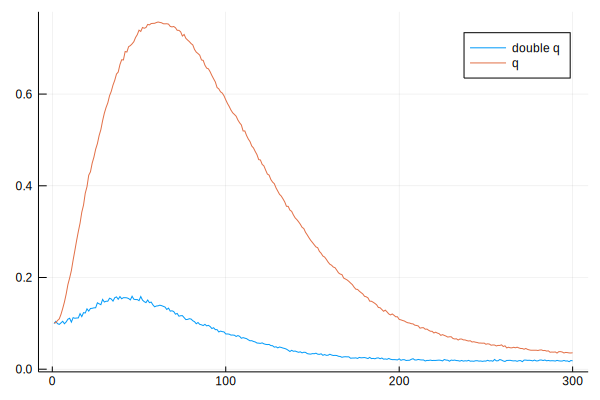

In [7]:
stats = []
for _ in 1:10000
    hook = CountOfLeft()
    run(init_Q_agent(), env, StopAfterEpisode(300);hook=hook)
    push!(stats, hook.counts)
end
plot!(mean(stats), legend=:topright, label="q")

# TODO

We need to add a legal action here to restrict that the actions of the first step can only be 1(left) or 2(right). So that the figure will look exactly like the one on the book.